# Generating Names with a Character-Level RNN


"""

Read it here https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In the last tutorial we used a RNN to classify names into their language 
of origin. This time we will turn around and generate names from 
languages.

> python sample.py Russian RUS
Rovakov
Uantov
Shavakov

> python sample.py German GER
Gerren
Ereng
Rosher

> python sample.py Spanish SPA
Salla
Parer
Allan

> python sample.py Chinese CHI
Chan
Hang
Iun

We are still hand-crafting a small RNN with a few linear layers
but instead of predicting a category after reading in all letters of the 
name we input a category and output one letter at a time

We will use the same data as the previous one

"""


# Preparing the Data

In [1]:

"""

we have a bunch of plain text files 
data/names/[Language].txt
with a name per line 

we will split the lines into an array
convert Unicode to ASCII
and end up with a dictionary

"""

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)




        


In [2]:

"""

remove one extra letter is kept to 
signify the end of the text generation
EOS marker so to speak

"""

print(n_letters)

# Turn a Unicode string to plain ASCII, 
# thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


59


In [3]:

# Read a file and split into lines
"""

read all the lines in a file 
and save each of all them seprately in a list called "lines"
then send them each through the function unicodeToAscii to convert
to plain ASCII
this return a list with each item being a particular word

"""        
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]



# Build the category_lines dictionary, a list of lines per category
"""

read each file separately 
category is the language name
all_categories stores the names of all the languages

lines is the list of all the words for that language 
as a list in ASCII format

category_lines is a dictionary with the key 
being the language name and the data corresponding to the key
being all the associated words with that language 
so category_lines dictionary structure is like this 

[english] : word1, word2, ....
[french] : word1, word2, ....

"""        
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
        
n_categories = len(all_categories)
        
if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')
        

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))
        


# categories: 18 ['Polish', 'Dutch', 'Italian', 'Portuguese', 'Greek', 'Japanese', 'French', 'English', 'Czech', 'Korean', 'Scottish', 'Spanish', 'Chinese', 'Vietnamese', 'German', 'Irish', 'Russian', 'Arabic']
O'Neal


# Creating the Network


In [4]:
# Read it here 
# https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#creating-the-network

"""
so here the input to the network is three things 
category tensor, input, hidden

category is a one-hot tensor (dim no of categories)
input is a one-hot tensor (dim no of n_letters)
output must be a probability of the next letter 
so output will be of dim of n_letters

[category, input, hidden] --> [combined]

[combined] --> i2o --> [output]

[combined] --> i2h --> [hidden] ==> input for next

[output, hidden] --> [out_combined]

[out_combined] --> o2o --> dropout --> softmax --> [output] ==> input for next



"""


import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


# Training

In [5]:

"""
Preparing for Training

a helper functions to get random pairs of
(category, line)
"""

import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]


# Get a random category and random line from that category
def randomTrainingPair():
    """
    randomly choose a category
    randomly choose a word from the category
    """
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line


In [6]:

"""
For each timestep ( that is for each letter in a training word ) the inputs
of the network will be

(category, current_letter, hidden_state)

and the outputs will be 

(next_letter, next_hidden_state)

Since we are predicting the next letter from the current letter for each 
timestep the letter pairs are groups of consecutive letters from the line 
e.g. "ABCD <EOS>"
we create tuples like this
("A","B"), ("B", "C"), ("C", "D"), ("D", "EOS")

category input is 1 X n_categories 

"""

# One-hot vector for category
"""
returns the category as a tensor of size 1 x n_categories
"""
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor


# One-hot matrix of first to last letters (not including EOS) for input
"""
this is a matrix which consist of the tensor representation of all 
the letters in a particular word 
tensor is of shape no_of_letters_in_word X 1 X total_no_letters_in_voc
"""
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor


# LongTensor of second letter to end (EOS) for target
"""
the same as the above function
but does it for the target instead


"""
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li 
                      in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)


In [7]:

line = "Devraj"

# this is for the input
tensor = inputTensor(line)

print(tensor.shape)

# this is for the output
tensor = targetTensor(line)

print(tensor.shape)

# so how is the target being generated ?
print(len(line))

# collecting the indexes of the letters which serves as the target
# look at that !! we are starting from range (1, ....)
# so ignoring the first letter this is because that is not the target
# for anything
# so total no of letters now collected is len(line)-1
letter_indexes = [all_letters.find(line[li]) for li 
                      in range(1, len(line))]
print(letter_indexes)

# we also need to append the <EOS> marker 
# at the end
letter_indexes.append(n_letters - 1) # EOS

print(letter_indexes)



torch.Size([6, 1, 59])
torch.Size([6])
6
[4, 21, 17, 0, 9]
[4, 21, 17, 0, 9, 58]


In [8]:

import time
import math

"""

For convenience during training we’ll make a randomTrainingExample 
function that fetches a random (category, line) pair and turns them
into the required (category, input, target) tensors.

"""
# Make category, input, and target tensors from a random category, 
# line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

"""
To keep track of how long training takes I am adding a timeSince
(timestamp) function which returns a human readable string:
"""

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



# Training the Network

In [9]:

"""

In contrast to classification, where only the last output is used, we 
are making a prediction at every step, so we are calculating loss at 
every step.

The magic of autograd allows you to simply sum these losses at each 
step and call backward at the end

"""

criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)



In [10]:

"""

Training is business as usual - call train a bunch of times and 
wait a few minutes, printing the current time and loss every 
print_every examples, and keeping store of an average loss per 
plot_every examples in all_losses for plotting later.

"""

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    
    # get the input data and target data
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()    
    target_line_tensor.unsqueeze_(-1)
    
    # initialize the hidden units 
    # note that the hidden units are needed to be initialized 
    # for each example
    # THIS IS VERY IMPORTANT
    hidden = rnn.initHidden()    
    
    # remove the previous gradients associated with the model
    rnn.zero_grad()
    
    # compute the loss
    # the loss is per letter actually 
    loss = 0    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    # accumulate the gradients
    loss.backward()
    
    # update the parameters of the network
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    loss = loss.item() / input_line_tensor.size(0)
    
    # compute the total loss 
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


0m 19s (5000 5%) 2.7879
0m 38s (10000 10%) 3.2476
0m 59s (15000 15%) 2.3882
1m 21s (20000 20%) 2.9987
1m 44s (25000 25%) 5.4546
2m 6s (30000 30%) 2.4591
2m 30s (35000 35%) 2.1456
2m 52s (40000 40%) 2.5166
3m 12s (45000 45%) 1.8937
3m 33s (50000 50%) 2.8977
3m 56s (55000 55%) 2.5118
4m 17s (60000 60%) 2.5876
4m 37s (65000 65%) 2.7188
4m 57s (70000 70%) 3.2569
5m 17s (75000 75%) 2.6766
5m 37s (80000 80%) 1.4945
5m 56s (85000 85%) 2.0171
6m 16s (90000 90%) 1.9868
6m 36s (95000 95%) 2.5930
6m 55s (100000 100%) 2.6025


# Plotting the Losses



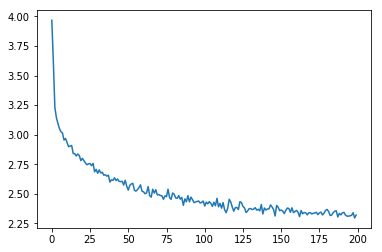

In [15]:

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


# Sampling the Network


"""

To sample we give the network a letter and ask what is the next one
feed that in as the next letter 
and repeat until the EOS token

to do so these steps are needed to be done 

1. create tensors for input category, starting letter and empty 
hidden state

2. create a string [output_name] with the starting letter 

3. up to a maximum output length 

3(a). feed the current letter to the network

3(b). get the next letter from the highest output and the next
hidden sate 

3(c). if the letter is <EOS> stop there 

3(d). if a regular letter comes up then add to the [output_name]
and continue

4. return the final name

"""


In [12]:

max_length = 20

# Sample from a category and starting letter

def sample(category, start_letter='A'):
    
    with torch.no_grad():  # no need to track history in sampling
        
        category_tensor = categoryTensor(category)
        
        input = inputTensor(start_letter)
        
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            
            output, hidden = rnn(category_tensor, input[0], hidden)
            
            topv, topi = output.topk(1)
            
            topi = topi[0][0]
            
            if topi == n_letters - 1:
                # search for the <EOS> marker 
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name


In [13]:

# Get multiple samples from one category and multiple starting letters

def samples(category, start_letters='ABC'):
    
    for start_letter in start_letters:
        
        print(sample(category, start_letter))




In [14]:

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

samples('English', 'ABC')


Rakovevov
Uarinov
Sakinovev
Garen
Erenger
Romer
Saner
Palla
Allos
Chan
Han
Iun
Allon
Balles
Cherton
